# Sheet 6

## 1 Autoencoders: theory and practice

# a)

Provide PyTorch code defining all three architectures. Pay particular attention to any non-linearities
and explain your choices.

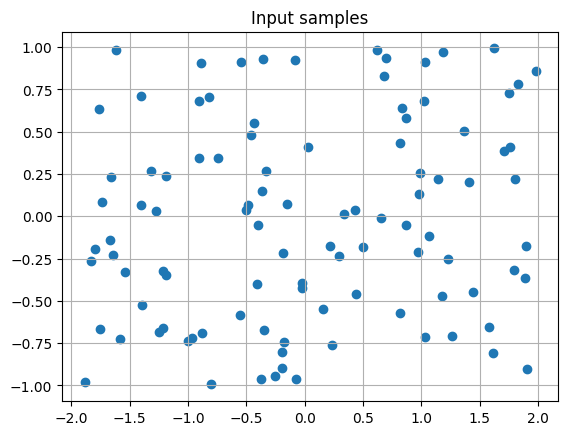

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


# a)

In [11]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

class Autoencoder(nn.Module):
    def __init__(self, hidden_channels, latent_dim=1, input_dim=2):
        """
        Initialize the autoencoder.

        Args:
            hidden_channels (list): Number of neurons in each layer. Special case for PCA: [input_dim, latent_dim, input_dim].
            input_dim (int): Number of input features.
            latent_dim (int): Number of dimensions in the latent space.
        """
        super().__init__()

        # TODO: implement the encoder and decoder

        # Check if the model should behave as PCA
        if hidden_channels == [input_dim, latent_dim, input_dim]:
            self.is_pca = True
            # Encoder and decoder for PCA: linear layers with no bias
            self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
            self.decoder = nn.Linear(latent_dim, input_dim, bias=False)
        else:
            self.is_pca = False
            # Build encoder
            encoder_layers = []
            in_features = input_dim
            for out_features in hidden_channels[:len(hidden_channels) // 2]:
                encoder_layers.append(nn.Linear(in_features, out_features))
                if out_features != latent_dim:  # Skip activation for the latent layer
                    encoder_layers.append(nn.GELU())
                in_features = out_features
            self.encoder = nn.Sequential(*encoder_layers)

            # Build decoder
            decoder_layers = []
            for out_features in hidden_channels[len(hidden_channels) // 2:]:
                decoder_layers.append(nn.Linear(in_features, out_features))
                if out_features != input_dim:  # Use sigmoid activation for the final layer
                    decoder_layers.append(nn.GELU())
                else:
                    decoder_layers.append(nn.Sigmoid())
                in_features = out_features
            self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Reconstructed tensor.
        """
        if self.is_pca:
            # PCA behavior: purely linear encoder and decoder
            z = self.encoder(x)  # Project to latent space
            x_hat = self.decoder(z)  # Reconstruct input
            return x_hat
        else:
            # Standard autoencoder
            x = self.encoder(x)
            x = self.decoder(x)
            return x

# Applying the autoencoder right now will we useful in the second part of step b

# First architecture: {20, 10, 1, 10, 20, 2}
autoencoder_1 = Autoencoder(hidden_channels=[20, 10, 1, 10, 20, 2])

# Second architecture: {50, 50, 50, 1, 50, 50, 50, 2}
autoencoder_2 = Autoencoder(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2])

# Third architecture: PCA
autoencoder_PCA = Autoencoder(hidden_channels=[2, 1, 2], input_dim=2, latent_dim=1)


class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())

        return optimizer

    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

We've chosen to use GELU and sigmoid activation functions in the neural networks's architecture.

GELU is used in the hidden layers.

The sigmoid function is used to produce the output. Since we're dealing with a binary classification problem, it's useful to have an output compressed between 0 (one class) and 1 (the other class)

# b)

In [12]:
# We train all 3 models with the provided code

# start the training using a PyTorch Lightning Trainer
trainer_1 = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

autoencoder_module_1 = AutoencoderModule(hidden_channels=[20, 10, 1, 10, 20, 2], input_dim=2, latent_dim=1)  # TODO: specify the model here
print("Model overview:", autoencoder_module_1)

trainer_1.fit(autoencoder_module_1, data_loader)

# start the training using a PyTorch Lightning Trainer
trainer_2 = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

autoencoder_module_2 = AutoencoderModule(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2], input_dim=2, latent_dim=1)  # TODO: specify the model here
print("Model overview:", autoencoder_module_2)

trainer_2.fit(autoencoder_module_2, data_loader)

# start the training using a PyTorch Lightning Trainer
trainer_PCA = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

autoencoder_module_PCA = AutoencoderModule(hidden_channels=[2, 1, 2], input_dim=2, latent_dim=1)  # TODO: specify the model here
print("Model overview:", autoencoder_module_PCA)

trainer_PCA.fit(autoencoder_module_PCA, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\roger\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
1

Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=20, out_features=2, bias=True)
      (5): Sigmoid()
    )
  )
)


c:\Users\roger\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\roger\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=50, out_features=2, bias=True)
      (7): Sigmoid()
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 4      | train
----------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Linear(in_features=2, out_features=1, bias=False)
    (decoder): Linear(in_features=1, out_features=2, bias=False)
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


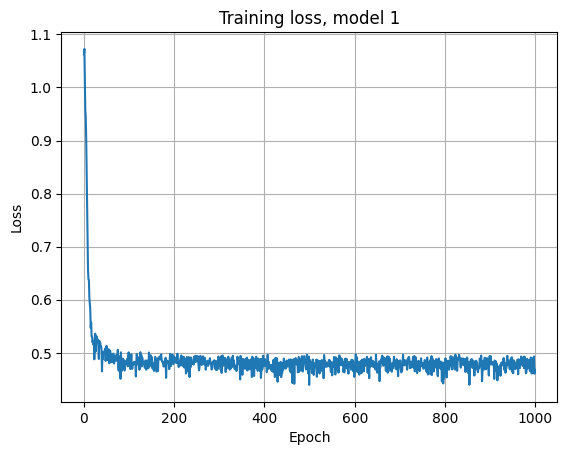

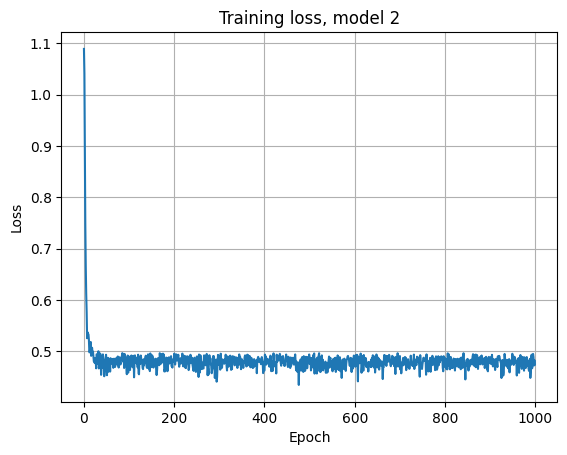

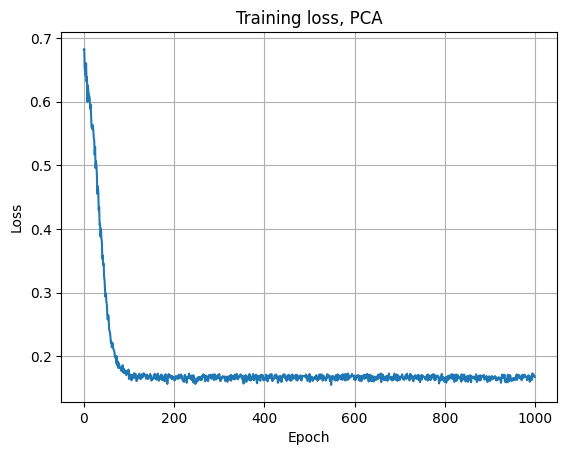

In [13]:
""" We extract the loss curve out of all classes. The original list has 12*1000 element,
while we have only executed 1000 epochs. This is because we're using 12 batches of 8
elements each.

It is convenient to calculate the mean of all batches for each epoch, that is,
for every 12 elements in the loss list in order to plot the loss curve as a
function of epochs.
"""

loss = np.mean(np.array(autoencoder_module_1.loss_curve).reshape(-1, 12), axis=1)
plt.plot(loss)
plt.title("Training loss, model 1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

loss =  np.mean(np.array(autoencoder_module_2.loss_curve).reshape(-1, 12), axis=1)
plt.plot(loss)
plt.title("Training loss, model 2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

loss = np.mean(np.array(autoencoder_module_PCA.loss_curve).reshape(-1, 12), axis=1)
plt.plot(loss)
plt.title("Training loss, PCA")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


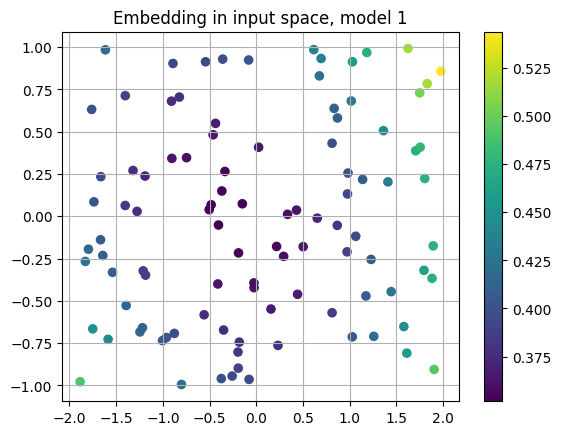

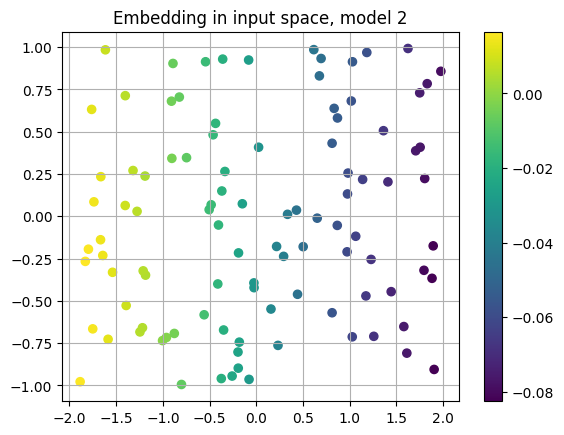

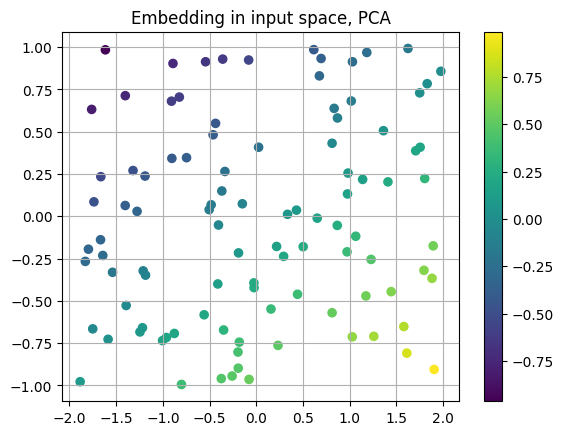

In [14]:
# Remake a dataset using the whole input
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

x, y = next(iter(data_loader))

# Calculate the embedding with each model.
# In order to plot the results, we've converted the torch tensors into numpy arrays
z_1 = autoencoder_1.encoder(x).detach().numpy()
z_2 = autoencoder_2.encoder(x).detach().numpy()
z_PCA = autoencoder_PCA.encoder(x).detach().numpy()

x_array = x.detach().numpy()
y_array = y.detach().numpy()

# Plot the input data colored with the embedding
plt.scatter(x_array[:,0], x_array[:,1], c=z_1, s=35)
plt.colorbar()
plt.grid(True)
plt.title("Embedding in input space, model 1")
plt.show()

plt.scatter(x_array[:,0], x_array[:,1], c=z_2, s=35)
plt.colorbar()
plt.grid(True)
plt.title("Embedding in input space, model 2")
plt.show()

plt.scatter(x_array[:,0], x_array[:,1], c=z_PCA, s=35)
plt.colorbar()
plt.grid(True)
plt.title("Embedding in input space, PCA")
plt.show()



The embedding color distribution suggests that the model 1 successfully captures some structure in the input data. Points that are spatially close in the original (x, y) space have similar embedding values (represented by colors). However, the variation of embedding values (colors) is somewhat abrupt, indicating that this model might not capture the relationships between points as smoothly as desired.

The embeddings for model 2 show smoother and more continuous changes in color across the input space. This suggests that the larger architecture (with more hidden neurons and layers) is better at learning the underlying structure of the data. Points closer together in the input space have embeddings that vary gradually, reflecting a better representation of the data.

The embeddings produced by the PCA-based model show an almost linear and continuous change in color. This is expected since PCA is a linear method designed to preserve as much variance as possible in a single dimension. PCA embeddings are purely geometric and don’t use non-linear transformations like neural networks.

So model 1 captures some patterns but lacks smoothness in embedding transitions, possibly due to its simpler architecture, whereas model 2 demonstrates superior learning of the data structure, with embeddings varying more naturally across the input space. Finally, PCA provides a baseline embedding that is smooth and linear but lacks the flexibility of non-linear models.


# c

Before training, the decoder has random weights due to the random initialization, so there’s no meaningful relationship between the latent space and the input space. Sampling points from the latent space will likely map to arbitrary, nonsensical patterns in the input space. These might look like random scattered points or unstructured curves.

After training, the decoder learns to reconstruct input data based on the latent embeddings. Sampling points from the latent space should map to structured patterns in the input space.

The curves of the model 1 in the input space will likely be simple and less smooth due to limited capacity. Expect some discontinuities or oversimplifications. The curves of the model 2 should be much smoother and better represent the data structure because the larger network can learn complex mappings. Finally, the curves of PCA will be straight lines or simple geometric shapes since PCA is linear.


# d

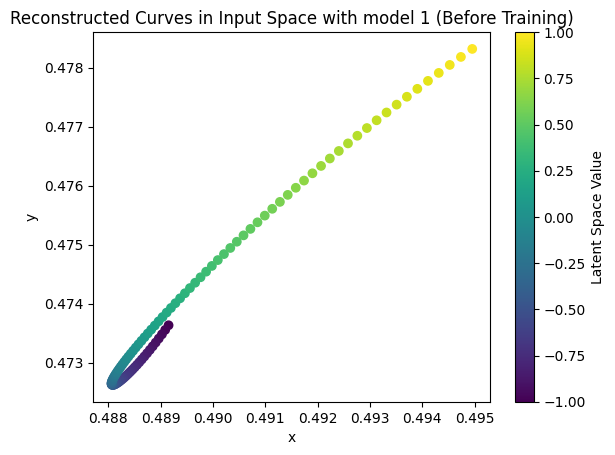

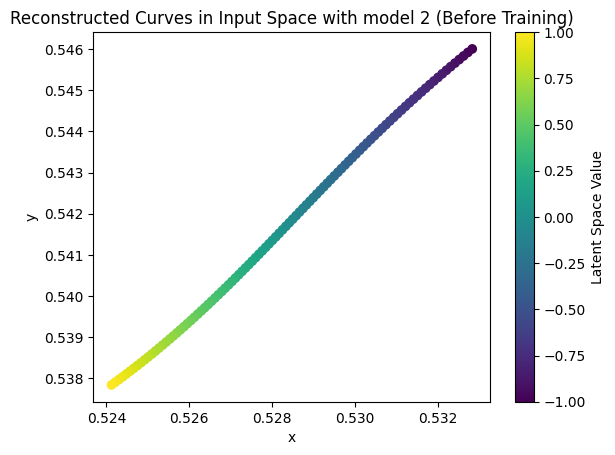

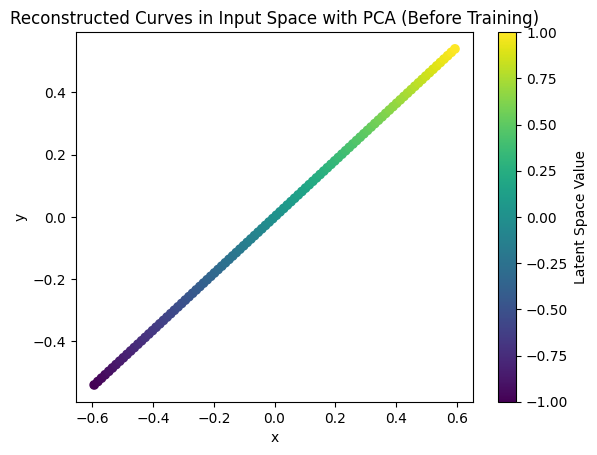

In [15]:
latent_samples = torch.linspace(-1, 1, 100).unsqueeze(1)  # 100 points in 1D latent space

# For untrained method
autoencoder_1_untrained = Autoencoder(hidden_channels=[20, 10, 1, 10, 20, 2])
autoencoder_2_untrained = Autoencoder(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2])
autoencoder_PCA_untrained = Autoencoder(hidden_channels=[2, 1, 2], input_dim=2, latent_dim=1)

reconstructed_points_rand_1 = autoencoder_1_untrained.decoder(latent_samples).detach().numpy()
reconstructed_points_rand_2 = autoencoder_2_untrained.decoder(latent_samples).detach().numpy()
reconstructed_points_rand_PCA = autoencoder_PCA_untrained.decoder(latent_samples).detach().numpy()


plt.scatter(reconstructed_points_rand_1[:, 0], reconstructed_points_rand_1[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with model 1 (Before Training)")
plt.show()

plt.scatter(reconstructed_points_rand_2[:, 0], reconstructed_points_rand_2[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with model 2 (Before Training)")
plt.show()


plt.scatter(reconstructed_points_rand_PCA[:, 0], reconstructed_points_rand_PCA[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with PCA (Before Training)")
plt.show()


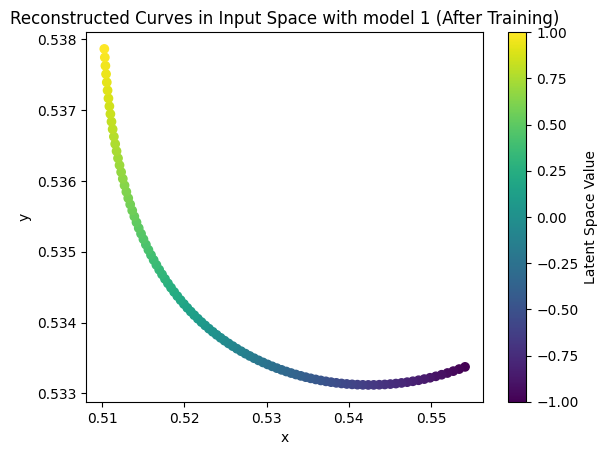

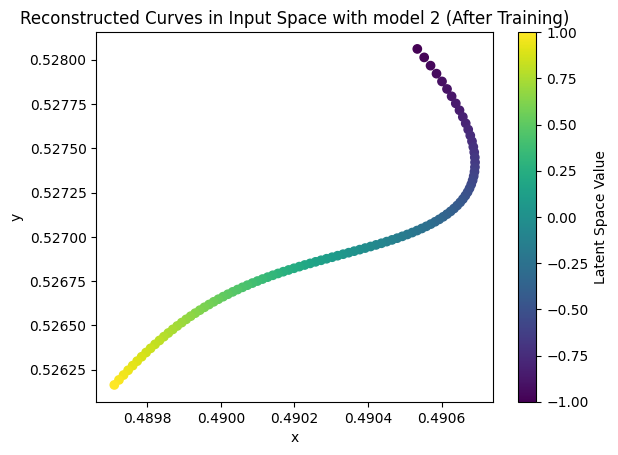

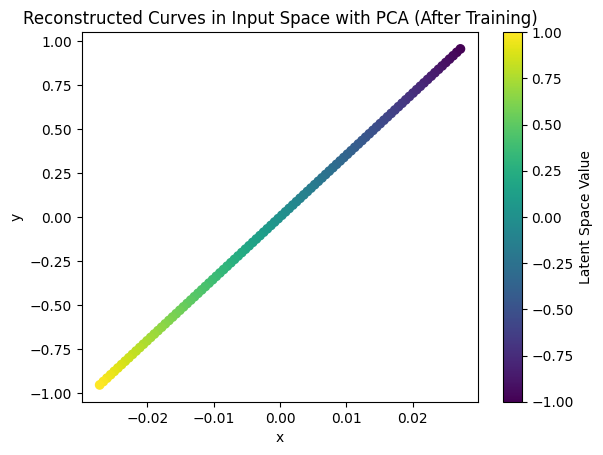

In [20]:
reconstructed_points_trained_1 = autoencoder_1.decoder(latent_samples).detach().numpy()
reconstructed_points_trained_2 = autoencoder_2.decoder(latent_samples).detach().numpy()
reconstructed_points_trained_PCA = autoencoder_PCA.decoder(latent_samples).detach().numpy()

plt.scatter(reconstructed_points_trained_1[:, 0], reconstructed_points_trained_1[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with model 1 (After Training)")
plt.show()

plt.scatter(reconstructed_points_trained_2[:, 0], reconstructed_points_trained_2[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with model 2 (After Training)")
plt.show()

plt.scatter(reconstructed_points_trained_PCA[:, 0], reconstructed_points_trained_PCA[:, 1], c=latent_samples.squeeze(), cmap='viridis')
plt.colorbar(label="Latent Space Value")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reconstructed Curves in Input Space with PCA (After Training)")
plt.show()


We can prove the hypotheses with this plots. Before training, the points or curves will look random and unstructured because the model is initialized with random weights. As a matter of fact, each time one runs the cell, one gets different reuslts for the plots, except with the PCA method. When plotting the trained model, the points will form smooth and meaningful curves that reflect the structure of your dataset. For the first two models, the values for the y axis are almost constant, with minimal variation compared to the x axis. This suggests that the decoder's mapping is capturing only limited variation along one dimension (likely due to the bottleneck being 1D). The curve effectively lies along a compressed structure in the input space. For the PCA model, the straight-line structures always represents the linear nature of PCA.

# e

Yes, an MLP autoencoder with a bottleneck dimension of 1 can perfectly reconstruct all n points under specific conditions, but only for finite n. 
If the dataset consists of n points, the bottleneck can still uniquely encode each point in the latent space (1D), because the model can learn a unique mapping from each point to its embedding. The decoder can then map this embedding back to the original points. For n points, the network acts as a lookup table: each point in R^p is encoded as a unique value in the bottleneck and decoded back.

With a sufficiently complex network (enough layers and neurons), the encoder and decoder can learn highly non-linear transformations that map the n points to distinct embeddings in the 1D latent space and back. This perfect reconstruction only applies to the training data. If new points (not in the training set) are given, the model will not generalize well due to the bottleneck’s limited capacity. Generalization requires the bottleneck to represent the structure of the data, not just memorize it.

# f

The decoder already represents a specific mapping from the latent space back to the input space. This mapping is trained to reconstruct the original input based on the latent embeddings provided by the encoder. When retraining the encoder, it will adjust to produce embeddings in the latent space that align with the fixed decoder's learned mapping. Since the decoder is not changing, the encoder has to learn a new representation of the input data that fits the decoder's expectations.

It is possible to have convergnece, when the encoder will successfully learn embeddings that the fixed decoder can decode to reconstruct the input data. This may still lead to good reconstructions if the decoder has enough capacity to generalize the mapping for different encoder representations.

If the decoder's mapping is rigid and does not align well with the new encoder's learned embeddings, the reconstruction quality might degrade. This happens because the encoder is forced to "fit" a pre-defined latent space, which might not perfectly represent the input data. Retraining the encoder might require more epochs and careful tuning, as it needs to align its learned embeddings precisely with the fixed decoder.

# g

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=50, out_features=2, bias=True)
      (7): Sigmoid()
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


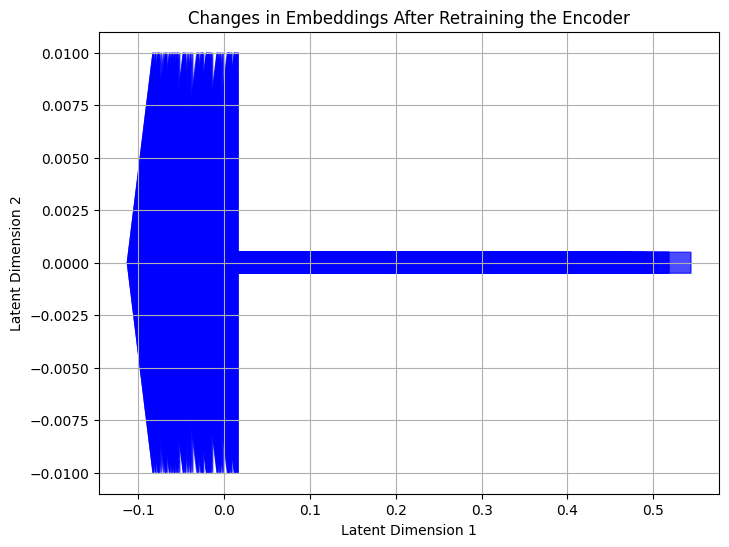

In [44]:
# Freeze the decoder parameters
for param in autoencoder_2.decoder.parameters():
    param.requires_grad = False
    
# start the training using a PyTorch Lightning Trainer
trainer_2 = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

autoencoder_module_2 = AutoencoderModule(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2], input_dim=2, latent_dim=1)  # TODO: specify the model here
print("Model overview:", autoencoder_module_2)

trainer_2.fit(autoencoder_module_2, data_loader)

# Get the original embeddings (before retraining)
original_embeddings = torch.from_numpy(z_1)

# Get the new embeddings (after retraining)
new_embeddings = autoencoder_2.encoder(x).detach().numpy()

plt.figure(figsize=(8, 6))
for i in range(len(original_embeddings)):
    plt.arrow(original_embeddings[i, 0], 0,  # Start at original embedding
              new_embeddings[i, 0] - original_embeddings[i, 0], 0,  # Change in embedding
              head_width=0.02, color='blue', alpha=0.7)  # Adjust visualization
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Changes in Embeddings After Retraining the Encoder")
plt.grid()
plt.show()


Each arrow shows how an embedding moves in the latent space after retraining the encoder. The starting points of the arrows are the original embeddings (before retraining). The arrowheads indicate the new embeddings (after retraining).

The embeddings primarily shift along the first latent dimension (x-axis), as expected for a 1D bottleneck.
The vertical spread (y-axis) is just for visualization since the embeddings are 1D, and their y-coordinate is essentially a constant.

The retraining process adjusts the embeddings to align with the fixed decoder’s expectations, leading to convergence in some regions.
Small or negligible arrow lengths for some points might indicate that their embeddings were already well-aligned with the fixed decoder.

Then, the retrained encoder successfully adapted the latent space to fit the frozen decoder.
The magnitude and direction of the arrows provide insight into how significantly the embeddings needed to change for the fixed decoder to reconstruct the input data correctly.

# h

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
c:\Users\roger\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


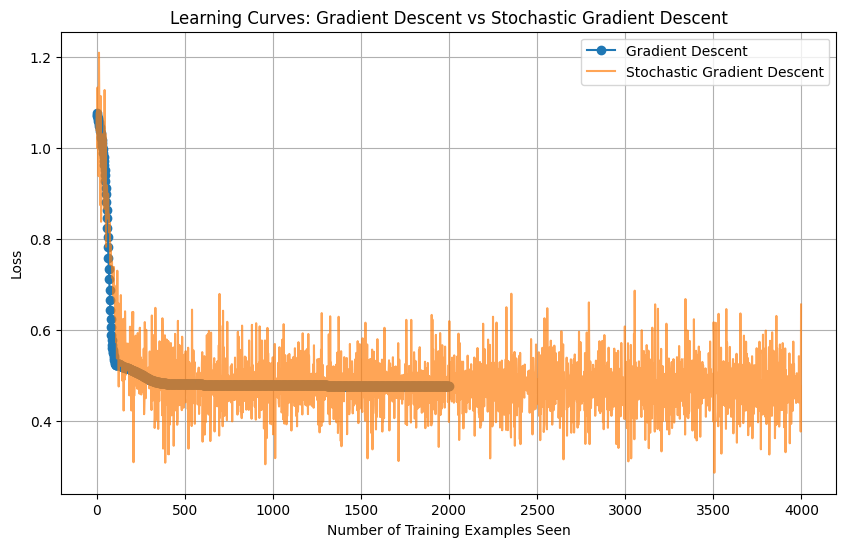

In [48]:
num_epochs = 1000
class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []
        self.examples_seen = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    def on_train_start(self):
        self.loss_curve = []
        self.examples_seen = []
        return super().on_train_start()

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        
        # Log loss and examples seen
        self.loss_curve.append(loss.item())
        self.examples_seen.append(self.global_step * len(batch))  # Examples seen so far
        
        return loss


    
# DataLoader for full-batch Gradient Descent
gd_data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)

# Train the model with GD
trainer_gd = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False)
autoencoder_gd = AutoencoderModule(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2])
trainer_gd.fit(autoencoder_gd, gd_data_loader)




# DataLoader for SGD
sgd_data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Train the model with SGD
trainer_sgd = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False)
autoencoder_sgd = AutoencoderModule(hidden_channels=[50, 50, 50, 1, 50, 50, 50, 2])
trainer_sgd.fit(autoencoder_sgd, sgd_data_loader)




# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(autoencoder_gd.examples_seen, autoencoder_gd.loss_curve, label="Gradient Descent", marker="o")
plt.plot(autoencoder_sgd.examples_seen, autoencoder_sgd.loss_curve, label="Stochastic Gradient Descent", alpha=0.7)
plt.xlabel("Number of Training Examples Seen")
plt.ylabel("Loss")
plt.title("Learning Curves: Gradient Descent vs Stochastic Gradient Descent")
plt.legend()
plt.grid()
plt.show()



The Gradient Descent learning curve (blue) is smooth, as expected. This is because each update in GD uses the entire dataset to compute the gradient, reducing noise in the optimization process. The loss decreases steadily over the number of training examples seen, showing consistent improvement. It converges relatively quickly to a stable loss value.

The Stochastic Gradient Descent learning curve (orange) is noisy, which is characteristic of SGD. Each update is based on a small batch, which introduces variance in the gradient estimates. Despite the noise, the overall trend shows a steady decrease in loss. The loss fluctuates around the minimum due to the inherent stochasticity of the method.

SGD achieves faster progress initially because it updates parameters more frequently, while GD waits for a full dataset pass to update. However, GD is more stable and consistent in reducing loss, while SGD exhibits noisy fluctuations. SGD processes more training examples overall (as evident from the x-axis), allowing it to make more updates within the same time frame.

So SGD reduces the loss faster in the early stages due to frequent updates, making it more suitable for scenarios where faster initial improvements are desired. At the same time, GD converges smoothly to the minimum, whereas SGD fluctuates near the minimum but may not settle as consistently. This is typical of SGD unless techniques like learning rate decay are applied. Then, GD is ideal for small datasets where computational cost is manageable and stability is crucial, while SGD is better suited for large datasets because it avoids processing the entire dataset at each step, offering faster updates but at the cost of more noise.